In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Understanding how the labels look

In [3]:
from glob import glob

In [4]:
# Path to train_annotations folder
annotation_path = "/kaggle/input/MABe-mouse-behavior-detection/train_annotation/"

# Selecting one parquet file from any subfolder
parquet_files = glob(os.path.join(annotation_path, "*/*.parquet"))

# Loading the first one
sample_file = parquet_files[0]
print("Loading: ", sample_file)

df = pd.read_parquet(sample_file)
print(df.head())

Loading:  /kaggle/input/MABe-mouse-behavior-detection/train_annotation/CRIM13/1763467574.parquet
   agent_id  target_id  action  start_frame  stop_frame
0         1          2  attack         1752        1846
1         1          2   sniff         1847        1912
2         1          2  attack         1913        1922
3         1          2  attack         1936        2124
4         1          2  attack         2157        2164


**Context:**

* `agent_id`: the mouse doing the action (attacking or sniffing)
* `target_id`: the mouse receiving the action
* `start_frame`-`stop_frame`: the time span (in frames) during which that action occurs


## Understanding tracking (pose) data

In [5]:
# Path to pose data
tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/train_tracking/"

# Selecting one tracking file from any subfolder
tracking_files = glob(os.path.join(tracking_path, "*/*.parquet"))

# Loading the first one
tracking_sampleFile = tracking_files[0]
print("Loading: ", tracking_sampleFile)

tracking_df = pd.read_parquet(tracking_sampleFile)
print(tracking_df.head())

Loading:  /kaggle/input/MABe-mouse-behavior-detection/train_tracking/CRIM13/1763467574.parquet
   video_frame  mouse_id   bodypart           x           y
0         1752         1   ear_left  122.905281  235.934219
1         1752         1  ear_right   98.905281  220.934219
2         1752         1   hip_left  133.905273  284.934235
3         1752         1  hip_right   88.905281  278.934235
4         1752         1       neck  106.905281  237.934219


**Context:**
* At **frame 1752, mouse 1** had those keypoint positions.
* Each bodypart (like hip_left, ear_right, neck, etc.) has (x, y) pixel coordinates

## Visualizing the pose for one mouse in one frame

In [6]:
import matplotlib.pyplot as plt

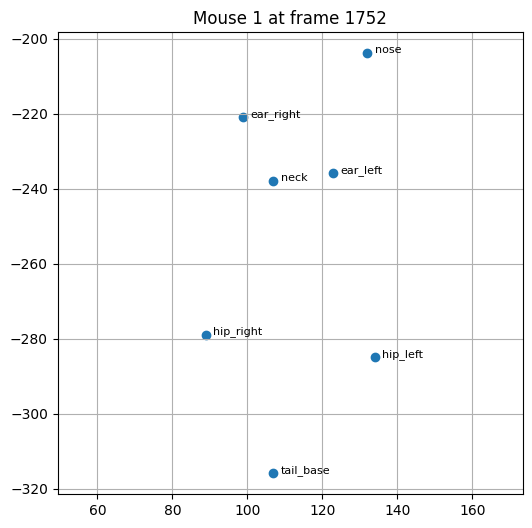

In [7]:
# Picking a specific frame and mouse
frame_to_plot = 1752
mouse_to_plot = 1

# Filter to that frame and mouse
pose_df = tracking_df[(tracking_df['video_frame'] == frame_to_plot) &
                    (tracking_df['mouse_id'] == mouse_to_plot)]

# Plot
plt.figure(figsize=(6,6))
plt.scatter(pose_df['x'], -pose_df['y'],
           label='keypoints')

# Annotate each point with bodypart name
for _, row in pose_df.iterrows():
    plt.text(row['x'] + 2, -row['y'], row['bodypart'], fontsize=8)

plt.title(f"Mouse {mouse_to_plot} at frame {frame_to_plot}")
plt.axis("equal")
plt.grid(True)
plt.show()

## Connecting keypoints (stick figure skeleton)

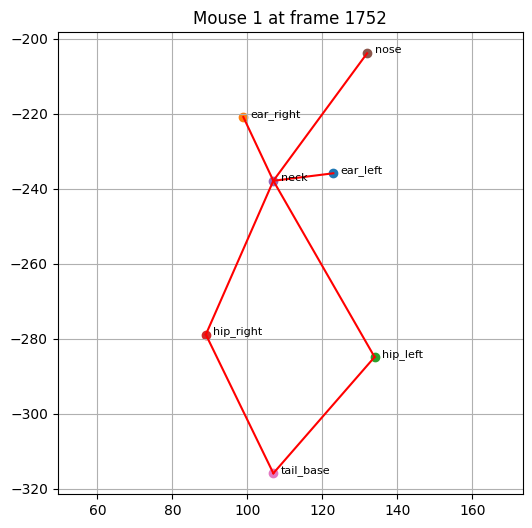

In [8]:
# Similar filtering
pose_df = tracking_df[(tracking_df['video_frame'] == frame_to_plot) &
                      (tracking_df['mouse_id'] == mouse_to_plot)]

# Creating lookup of bodypart (x, y)
points = {
    row['bodypart']: (row['x'], row['y']) for _, row in pose_df.iterrows()
}

# Draw
plt.figure(figsize=(6,6))
for part, (x,y) in points.items():
    plt.scatter(x, -y)
    plt.text(x + 2, -y, part, fontsize=8)

# Stick connections
connections = [
    ('nose', 'neck'),
    ('neck', 'hip_left'),
    ('neck', 'hip_right'),
    ('hip_left', 'tail_base'),
    ('hip_right', 'tail_base'),
    ('neck', 'ear_left'),
    ('neck', 'ear_right'),
]

for a, b in connections:
    if a in points and b in points:
        x1, y1 = points[a]
        x2, y2 = points[b]
        plt.plot([x1, x2], [-y1, -y2], color='red')

plt.title(f"Mouse {mouse_to_plot} at frame {frame_to_plot}")
plt.axis("equal")
plt.grid(True)
plt.show()

## Animating 10 frames of one mouse's skeleton

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [14]:
# Selecting the mouse and frame range
mouse_id = 1
start_frame = 1752
num_frames = 10
frames = list(range(start_frame, start_frame + num_frames))

# Filtering tracking data for these frames
sub_df = tracking_df[
(tracking_df['mouse_id'] == mouse_id) &
(tracking_df['video_frame'].isin(frames))
]

# Set up the plot
fig, ax = plt.subplots(figsize=(6,6))
scatter_pts = ax.scatter([], [], s=50)
lines = []

# Using the same connections list as above
for _ in connections:
    line, = ax.plot([], 'r-', lw=2)
    lines.append(line)

text_labels = []

def init():
    ax.set_xlim(50, 180)
    ax.set_ylim(-330, -190)
    ax.set_title(f"Mouse {mouse_id} movement")
    return [scatter_pts] + lines + text_labels

def update(frame_num):
    frame = frames[frame_num]
    pose = sub_df[sub_df['video_frame'] == frame]

    xs = pose['x'].values
    ys = -pose['y'].values
    scatter_pts.set_offsets(list(zip(xs, ys)))

    # Line updates
    points = {row['bodypart']: (row['x'], -row['y']) for _, row in pose.iterrows()}
    for i, (a, b) in enumerate(connections):
        if a in points and b in points:
            x1, y1 = points[a]
            x2, y2 = points[b]
            lines[i].set_data([x1, x2], [y1, y2])

        else:
            lines[i].set_data([], [])

    return [scatter_pts] + lines

anim = FuncAnimation(fig, update, frames=len(frames), init_func=init,
                    blit = True)
plt.close()
HTML(anim.to_jshtml())